<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/DSR_1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(mnist_train,mnist_validate, mnist_test), info = tfds.load(
    name='mnist',
    split = ["train[0:80%]","train[80%:]","test"], #train, validate, test
    with_info = True,
    as_supervised = True
)
print (info)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs 

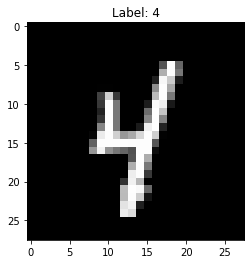

In [4]:
for image, label in mnist_train.take(1):
  plt.imshow(image.numpy().squeeze(), cmap="gray") #change the EagerTensor object to numpy, and remove the pseudo dimension with size 1
  plt.title(f"Label: {label}")
  plt.show()

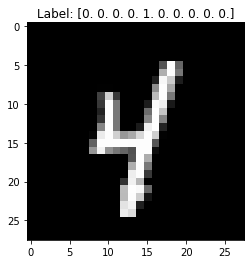

In [15]:
def encode(image, label):
  # tensorflow expects the inputs to be in float32 and it's a good idea to normalize
  # converting the dtype to float 32 does it all
  image_encoded = tf.image.convert_image_dtype(image,dtype=tf.float32)
  #label_encoded = tf.image.convert_image_dtype(label,dtype=tf.float32)
  label_encoded = tf.one_hot(label, depth=10)
  return image_encoded, label_encoded

#mnist_train_pipeline = mnist_train.map(lambda image, label: encode(image,label))
mnist_train_pipeline = mnist_train.map(lambda image, label: encode(image,label))
mnist_validate_pipeline = mnist_validate.map(lambda image, label: encode(image,label))
mnist_test_pipeline = mnist_validate.map(lambda image, label: encode(image,label))

for image, label in mnist_train_pipeline.shuffle(1).take(1):
  plt.imshow(image.numpy().squeeze(), cmap="gray") #change the EagerTensor object to numpy, and remove the pseudo dimension with size 1
  plt.title(f"Label: {label}")
  plt.show()

In [41]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28,28,1)))
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))  #relu is a cheap nonlinear function, and is usually a good start
model.add(layers.Dense(10, activation="softmax")) #softmax means all output will sum up to one, and each output value will be between 0-1. Good choice for classificaiton
model.summary()

model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


(1, 28, 28, 1)
(1, 10)
1/1 [==============================] - 0s 30ms/step
(1, 10)


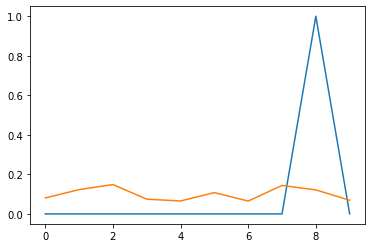

In [23]:
for image,label in mnist_test_pipeline.batch(12).take(1):
#for image,label in mnist_test_pipeline.take(1):
  print (image.shape)
  print(label.shape)

  plt.plot(label[0])

  prediction = model.predict(image)
  print(prediction.shape) 
  plt.plot(prediction[0]) 

In [24]:
loss, accuracy = model.evaluate(mnist_test_pipeline.batch(32), verbose=0)
print(loss)
print(accuracy)

2.387122869491577
0.07999999821186066


In [44]:
history = model.fit(
    mnist_train_pipeline.shuffle(48000).batch(128), # we shuffle to avoid model overfitting the order of batches.
    epochs = 10,
    validation_data = mnist_validate_pipeline.batch(128)
)

Epoch 1/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0484 - accuracy: 0.9861 - val_loss: 0.0879 - val_accuracy: 0.9750
Epoch 2/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0385 - accuracy: 0.9888 - val_loss: 0.0808 - val_accuracy: 0.9753
Epoch 3/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.0774 - val_accuracy: 0.9764
Epoch 4/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0243 - accuracy: 0.9937 - val_loss: 0.0773 - val_accuracy: 0.9765
Epoch 5/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0187 - accuracy: 0.9956 - val_loss: 0.0735 - val_accuracy: 0.9786
Epoch 6/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0162 - accuracy: 0.9960 - val_loss: 0.0782 - val_accuracy: 0.9778
Epoch 7/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0128 - accuracy: 0.9974 - val_loss: 0.0770 - val_accuracy: 0.9787
Epoch 

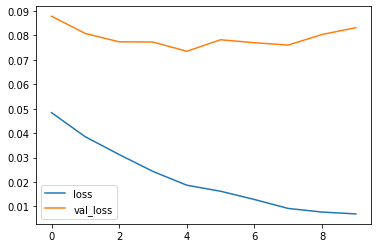

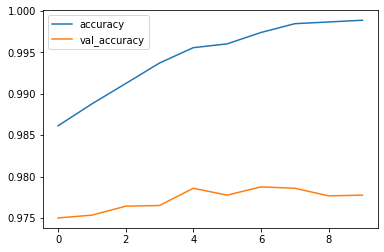

In [45]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()
plt.close()

In [49]:
#To be able to go back in time to a good epoch size
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
EPOCHS = 10
checkpoint_filepath = 'mnist/checkpoints/checkpoint_test1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])
history = model.fit(
    mnist_train_pipeline.shuffle(48000).batch(128), # we shuffle to avoid model overfitting the order of batches.
    epochs = EPOCHS,
    validation_data = mnist_validate_pipeline.batch(128),
    callbacks=[model_checkpoint_callback]
)


# If save_best_only, following loads the best model weights (that are considered the best) into the model.
#model.load_weights(checkpoint_filepath)


Epoch 1/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0831 - val_accuracy: 0.9793
Epoch 2/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0846 - val_accuracy: 0.9782
Epoch 3/10
375/375 [==============================] - 3s 4ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0843 - val_accuracy: 0.9802
Epoch 4/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0828 - val_accuracy: 0.9800
Epoch 5/10
375/375 [==============================] - 4s 6ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0832 - val_accuracy: 0.9803
Epoch 6/10
375/375 [==============================] - 4s 6ms/step - loss: 9.0079e-04 - accuracy: 1.0000 - val_loss: 0.0847 - val_accuracy: 0.9799
Epoch 7/10
375/375 [==============================] - 4s 6ms/step - loss: 7.4073e-04 - accuracy: 1.0000 - val_loss: 0.0881 - val_accuracy: 0.979

In [51]:
#To monitor training, we can use TensorBoard:
# https://www.tensorflow.org/tensorboard/get_started
#Using TensorBoard with Keras Model.fit()
#When training with Keras's Model.fit(), adding the tf.keras.callbacks.TensorBoard callback ensures that logs are created and stored. 
#Additionally, enable histogram computation every epoch with histogram_freq=1 (this is off by default)
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

import datetime
log_dir = "mnist/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    mnist_train_pipeline.shuffle(48000).batch(128), # we shuffle to avoid model overfitting the order of batches.
    epochs = EPOCHS,
    validation_data = mnist_validate_pipeline.batch(128),
    callbacks=[tensorboard_callback]
)




Epoch 1/10
375/375 [==============================] - 4s 8ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0987 - val_accuracy: 0.9781
Epoch 2/10
375/375 [==============================] - 3s 5ms/step - loss: 8.2325e-04 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9797
Epoch 3/10
375/375 [==============================] - 3s 5ms/step - loss: 4.9141e-04 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 0.9793
Epoch 4/10
375/375 [==============================] - 3s 5ms/step - loss: 3.2754e-04 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 0.9799
Epoch 5/10
375/375 [==============================] - 3s 5ms/step - loss: 2.8166e-04 - accuracy: 1.0000 - val_loss: 0.0939 - val_accuracy: 0.9801
Epoch 6/10
375/375 [==============================] - 3s 5ms/step - loss: 2.4734e-04 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 0.9803
Epoch 7/10
375/375 [==============================] - 5s 9ms/step - loss: 2.2399e-04 - accuracy: 1.0000 - val_loss: 0.0953 - val

In [ ]:
%tensorboard --logdir logs/fit

In [50]:
#power consumption
!nvidia-smi

Tue Oct 25 14:26:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    29W /  70W |    492MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------